# Exploratory Data Analysis Notebook

### Description

This is the May 2025 podcast listening time podcast prediction competition.

The goal is to analyze and predict the average calories burn per workout.

### Files
1. train.csv
2. test.csv
3. sample_submission.csv

### Evaluation

The evaluation metric for this competition is Root Mean Squared Logarithmic Error..

Submission File
For each id in the test set, you must predict the number of minutes listened. The file should contain a header and have the following format:

- id,Listening_Time_minutes
- 26570,0.2
- 26571,0.1
- 26572,0.9
- etc.

## Package Importing

In [1]:
# general python libraries
import time
import sys
import datetime
import math
import numpy as np

# dataframe and data manipulation library
import pandas as pd

# visualisation and EDA libraries
import matplotlib.pyplot as  plt
import ydata_profiling
import seaborn as sns

# machine learning libraries
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import metrics

## Data Importing

In [15]:
TARGET_COLUMN = 'Calories'

In [16]:
folder_path = '../data/raw'
train_data = pd.read_csv(f'{folder_path}/train.csv', index_col='id')
test_data = pd.read_csv(f'{folder_path}/test.csv', index_col='id')
sample = pd.read_csv(f'{folder_path}/sample_submission.csv', index_col='id')

## Dataset Summaries and Heads

In [17]:
print("Number of rows in train data:    \t",train_data.shape[0])
print("Number of columns in train data: \t",train_data.shape[1])
print("\nNumber of rows in test data:     \t",test_data.shape[0])
print("Number of columns in test data:  \t",test_data.shape[1])
print("\nNumber of rows in sample data:   \t",sample.shape[0])
print("Number of column in sample data: \t",sample.shape[1])

Number of rows in train data:    	 750000
Number of columns in train data: 	 8

Number of rows in test data:     	 250000
Number of columns in test data:  	 7

Number of rows in sample data:   	 250000
Number of column in sample data: 	 1


In [18]:
# check datatypes of columns
print(train_data.dtypes.value_counts())

float64    6
object     1
int64      1
Name: count, dtype: int64


non-numeric column categories based on data from  750000 rows


Text(0, 0.5, 'number_of_distinct_categories')

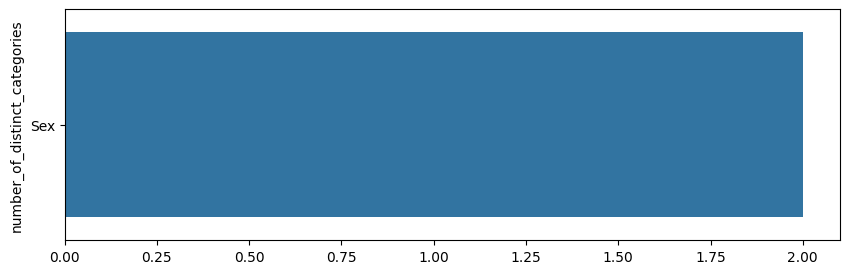

In [19]:
# save names of categorical columns
numeric_cols = train_data.dtypes[train_data.dtypes != "object"].index
cat_cols = train_data.dtypes[train_data.dtypes == "object"].index

# view cardinalitites of categorical columns
print('non-numeric column categories based on data from ', train_data.shape[0],'rows')

cat_name = []
nunique_vals = []
for i in cat_cols:
    cat_name.append(i)
    nunique_vals.append(train_data.loc[:,i].nunique())

cat_counts = pd.Series(data=nunique_vals,index=cat_name).sort_values(ascending = False)

fig = plt.figure(figsize=(10,3*len(cat_counts)))
ax = sns.barplot(y = cat_counts.index, x = cat_counts, orient='h')

ax.set_xlabel(None)
ax.set_ylabel('number_of_distinct_categories')

In [20]:
train_data.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
id,,,,,,,,
0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,female,38,166.0,61.0,25.0,102.0,40.6,146.0


In [21]:
test_data.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
id,,,,,,,
750000,male,45,177.0,81.0,7.0,87.0,39.8
750001,male,26,200.0,97.0,20.0,101.0,40.5
750002,female,29,188.0,85.0,16.0,102.0,40.4
750003,female,39,172.0,73.0,20.0,107.0,40.6
750004,female,30,173.0,67.0,16.0,94.0,40.5


In [22]:
sample.head()

,Calories
id,
750000,88.283
750001,88.283
750002,88.283
750003,88.283
750004,88.283


In [23]:
# checking missing data
total = train_data.isnull().sum().sort_values(ascending = False)
percent = (train_data.isnull().sum()/train_data.isnull().count()*100).sort_values(ascending = False)
missing_train_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_train_data

,Total,Percent
Sex,0,0.0
Age,0,0.0
Height,0,0.0
Weight,0,0.0
Duration,0,0.0
Heart_Rate,0,0.0
Body_Temp,0,0.0
Calories,0,0.0


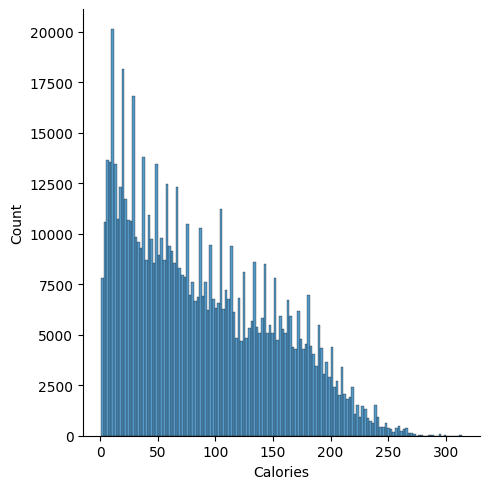

In [27]:
# checking target variable percentage
sns.displot(x="Calories", data=train_data)

In [20]:
train_data.columns

Index(['id', 'Podcast_Name', 'Episode_Title', 'Episode_Length_minutes',
       'Genre', 'Host_Popularity_percentage', 'Publication_Day',
       'Publication_Time', 'Guest_Popularity_percentage', 'Number_of_Ads',
       'Episode_Sentiment', 'Listening_Time_minutes'],
      dtype='object')

each of the products could have very different behaviours and be from different populations. And so it may make sense to look at each on of these individually

## Static Profiling

In [ ]:
# sample data if required if reports too big
# train_sample = train_data.sample(10000)

# drop id column
# train_sample.drop('id',axis = 1, inplace=True)

# drop index or else that will also be profiled
# train_sample.reset_index(drop=True, inplace=True)

In [23]:
# create minimal report in reports
minimal_report = train_data.profile_report(title="Minimal Report",minimal=True)
minimal_report.to_file("../reports/pp_eda_minimal.html")
#minimal_report.to_notebook_iframe()

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 312.31it/s]


In [28]:
# set of parameters to create customer report
train_data.profile_report(
    title="Custom Report",
    # create missing/null value diagrams
    # disable if no missing values
    missing_diagrams={
        "heatmap": True,
        "dendrogram": True,
        "bar": True,
        "matrix":True
    # create all correlation plots
    # the correlations and interactions come together
    # the correlations section dictates which corrs will be run
    # the interactions dicatates which variables
    },correlations={
        # strength and directional
        # continuous vars, linear, sensitive to outliers, normal dist
        "pearson": {"calculate": True},
        # strength and directional
        # categorical or quant, linear, no outliers
        "spearman": {"calculate": False},
        # 0-1
        # dependence of 2 vars.
        "kendall": {"calculate": True},
        # no direction, categorical, ordinal, interval
        # non-linear dependency
        # computationally expensive
        "phi_k": {"calculate": True}, # this one is one of the most intensive ones
        # compares 2 categorical vars
        # based on chi-squared test stat
        # sensitive to outlies
        "cramers": {"calculate": True}
    },interactions = {
        # this generates 2d scatter, this will cause crash if too many variables
        "continuous": False,
        # comment continouous out and put in 
        # target var to see scatter between
        # only these values and all other
        # values
        "targets": ['Listening_Time_minutes']
    },html = {
        "style": {"theme":"flatly"}
    }
    
    
).to_file("../reports/pp_eda_custom.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 20.26it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Exception ignored in: <function ResourceTracker.__del__ at 0x1064c8680>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.12/3.12.10/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/opt/homebrew/Cellar/python@3.12/3.12.10/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/opt/homebrew/Cellar/python@3.12/3.12.10/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x107474680>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.12/3.12.10/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/opt/homebrew/Cellar/python@3.12/3.12.10/Frameworks/Python.framework/

## Data Cleaning

Creation of data cleaning function to;
- Impute NULL Values
- Parse Multi-part string columns
- Drop columns
- Encode categorical variables
- Normalise or scale columns

In [15]:
def Preprocessing(df):
    
    df = pd.get_dummies(df) # convert all categorical variables to dummy variables
    
    df = df.dropna(
        # axis = 1 # default both axes, comment out for only 1 axis
    ) # remvoe all na rows or columns
    
    return df

train_data_cleaned = Preprocessing(train_data)

print("missing values present:",train_data_cleaned.isna().sum().sum())
print("categorical columns present:",train_data_cleaned.dtypes[train_data_cleaned.dtypes == "object"].count())



missing values present: 0
categorical columns present: 0


## Model fitting

### Train Test Split

Splitting data into groupings for model fitting

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    train_data_cleaned.drop(['id','failure'], axis = 1), # X data excluding target variable and any irrelevant id columns
    train_data_cleaned.loc[:,'failure'],
    test_size = 0.2, # 0.2 is a good accepted starting point, with larger data this number can be decreased
    random_state = 42, # random seed, default 42
    shuffle = True # default true, check whether there is population drift over time in default order
)

print("Shape of X_train data:    \t",X_train.shape)
print("Shape of X_test data:    \t",X_test.shape)
print("Shape of y_train data:    \t",y_train.shape)
print("Shape of y_test data:    \t",y_test.shape)

Shape of X_train data:    	 (9746, 31)
Shape of X_test data:    	 (2437, 31)
Shape of y_train data:    	 (9746,)
Shape of y_test data:    	 (2437,)


### Linear Regression

In [17]:
from sklearn.linear_model import LinearRegression
# help(LinearRegression)

In [18]:
# initialise new linear regression object model
model = LinearRegression()

In [19]:
# Fir regression model
model.fit(X_train, y_train)

LinearRegression()

In [20]:
# predict values on test set
test_preds = model.predict(X_test)

In [ ]:
test_residuals = y_test - test_preds

# ideally this is normal
sns.scatterplot(x=y_test,y=test_residuals)
plt.axhline(y=0,color='r',ls='--')

In [ ]:
# these coeffients will be in different units
model.coef_

In [ ]:
from joblib import dump, load
dump(model,'../models/linear_regression_model.joblib')